<a href="https://colab.research.google.com/github/RaymondEmory/Pytorch/blob/main/Custom_PyTorch_Text_Classification_CNN_(v3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2021-07-24 19:04:27--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.009s  

2021-07-24 19:04:27 (55.5 MB/s) - ‘spam.csv’ saved [503663/503663]



In [ ]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [ ]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# rename columns to something better
df.columns = ['labels', 'data']

In [ ]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.33)

In [ ]:
df_train.shape, df_test.shape

((3733, 3), (1839, 3))

In [ ]:
# 0 = padding
idx = 1
word2idx = {'<PAD>': 0}

In [ ]:
# you could always use gensim or spacy for tokenization,
# but let's keep it simple!
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split() # simple tokenization
  for token in tokens:
    if token not in word2idx:
      word2idx[token] = idx
      idx += 1

In [ ]:
word2idx

{'<PAD>': 0,
 "i'm": 1,
 'gonna': 2,
 'be': 3,
 'home': 4,
 'soon': 5,
 'and': 6,
 'i': 7,
 "don't": 8,
 'want': 9,
 'to': 10,
 'talk': 11,
 'about': 12,
 'this': 13,
 'stuff': 14,
 'anymore': 15,
 'tonight,': 16,
 'k?': 17,
 "i've": 18,
 'cried': 19,
 'enough': 20,
 'today.': 21,
 'nowadays': 22,
 'people': 23,
 'are': 24,
 'notixiquating': 25,
 'the': 26,
 'laxinorficated': 27,
 'opportunity': 28,
 'for': 29,
 'bambling': 30,
 'of': 31,
 'entropication....': 32,
 'have': 33,
 'you': 34,
 'ever': 35,
 'oblisingately': 36,
 'opted': 37,
 'ur': 38,
 'books': 39,
 'masteriastering': 40,
 'amplikater': 41,
 'fidalfication?': 42,
 'it': 43,
 'is': 44,
 'very': 45,
 'champlaxigating,': 46,
 'think': 47,
 'atrocious..': 48,
 'wotz': 49,
 'opinion????': 50,
 'junna': 51,
 'hi': 52,
 'im': 53,
 'having': 54,
 'most': 55,
 'relaxing': 56,
 'time': 57,
 'ever!': 58,
 'we': 59,
 'get': 60,
 'up': 61,
 'at': 62,
 '7am': 63,
 'every': 64,
 'day!': 65,
 'was': 66,
 'party': 67,
 'good': 68,
 'other'

In [ ]:
len(word2idx)

10565

In [ ]:
# convert data into word indices
# note: could have done this on the fly earlier
train_sentences_as_int = []
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens]
  train_sentences_as_int.append(sentence_as_int)

In [ ]:
test_sentences_as_int = []
for i, row in df_test.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
  test_sentences_as_int.append(sentence_as_int)

In [ ]:
len(train_sentences_as_int), len(test_sentences_as_int)

(3733, 1839)

In [ ]:
def data_generator(X, y, batch_size=32):
  X, y = shuffle(X, y)
  n_batches = int(np.ceil(len(y) / batch_size))
  for i in range(n_batches):
    end = min((i + 1) * batch_size, len(y))

    X_batch = X[i * batch_size:end]
    y_batch = y[i * batch_size:end]

    # pad X_batch to be N x T
    max_len = np.max([len(x) for x in X_batch])
    for j in range(len(X_batch)):
      x = X_batch[j]
      pad = [0] * (max_len - len(x))
      X_batch[j] = pad + x
    
    # convert to tensor
    X_batch = torch.from_numpy(np.array(X_batch)).long()
    y_batch = torch.from_numpy(np.array(y_batch)).long()
    
    yield X_batch, y_batch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# What is the shape of embedding output?
# N x T x D
embed = nn.Embedding(len(word2idx), 20)
for inputs, targets in data_generator(train_sentences_as_int, df_train.b_labels):
  out = embed(inputs)
  print("Input shape:", inputs.shape)
  print("Output shape:", out.shape)
  break

Input shape: torch.Size([32, 40])
Output shape: torch.Size([32, 40, 20])


In [ ]:
# Define the model
class CNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_outputs):
    super(CNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.K = n_outputs

    # if input is T words
    # then output is (T, D) matrix
    self.embed = nn.Embedding(self.V, self.D)

    # conv layers
    self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1)
    self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
    self.pool2 = nn.MaxPool1d(2)
    self.conv3 = nn.Conv1d(64, 128, 3, padding=1)
    
    self.fc = nn.Linear(128, self.K)
  
  def forward(self, X):
    # embedding layer
    # turns word indexes into word vectors
    out = self.embed(X)

    # note: output of embedding is always
    # (N, T, D)
    # conv1d expects
    # (N, D, T)

    # conv layers
    out = out.permute(0, 2, 1)
    out = self.conv1(out)
    out = F.relu(out)
    out = self.pool1(out)
    out = self.conv2(out)
    out = F.relu(out)
    out = self.pool2(out)
    out = self.conv3(out)
    out = F.relu(out)

    # change it back
    out = out.permute(0, 2, 1)

    # max pool
    out, _ = torch.max(out, 1)

    # final dense layer
    out = self.fc(out)
    return out

In [ ]:
model = CNN(len(word2idx), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(10565, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train_gen = lambda: data_generator(train_sentences_as_int, df_train.b_labels)
test_gen = lambda: data_generator(test_sentences_as_int, df_test.b_labels)

In [ ]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_gen():
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      targets = targets.view(-1, 1).float()
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      # print("outputs.shape:", outputs.shape)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for inputs, targets in test_gen():
      inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, 8)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/8, Train Loss: 0.4016,       Test Loss: 0.3601, Duration: 0:00:00.801079
Epoch 2/8, Train Loss: 0.2817,       Test Loss: 0.1615, Duration: 0:00:00.383140
Epoch 3/8, Train Loss: 0.1528,       Test Loss: 0.1236, Duration: 0:00:00.385756
Epoch 4/8, Train Loss: 0.1069,       Test Loss: 0.1042, Duration: 0:00:00.385642
Epoch 5/8, Train Loss: 0.0711,       Test Loss: 0.0956, Duration: 0:00:00.378816
Epoch 6/8, Train Loss: 0.0685,       Test Loss: 0.0930, Duration: 0:00:00.395351
Epoch 7/8, Train Loss: 0.0441,       Test Loss: 0.0902, Duration: 0:00:00.384523
Epoch 8/8, Train Loss: 0.0293,       Test Loss: 0.0902, Duration: 0:00:00.387490


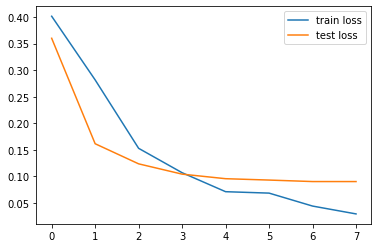

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9954, Test acc: 0.9734
